In [4]:
%load_ext autoreload
%autoreload 2
import sys

import numpy as np

sys.path.append("..")

import matplotlib.pyplot as plt

from xlstm_scaling_laws.model_accounting.flops.attention_op import (
    count_flops_attention_prefill,
)
from xlstm_scaling_laws.model_accounting.flops.llama_backbone import (
    count_flops_llama_backbone,
)
from xlstm_scaling_laws.model_accounting.memops.attention_op import (
    count_memops_attention_prefill,
)
from xlstm_scaling_laws.model_accounting.memops.llama_backbone import (
    count_memops_llama_backbone,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
llama_160m = {
    "d_model": 512,
    "d_kv": 64,
    "d_ff": 2048,
    "num_heads": 12,
    "num_layers": 12,
    "vocab_size": 50304,
}

llama_1_4b = {
    "d_model": 2048,
    "d_kv": 128,
    "d_ff": 5632,
    "num_heads": 16,
    "num_layers": 24,
    "vocab_size": 50304,
}

llama_7b = {
    "d_model": 4096,
    "d_kv": 128,
    "d_ff": 11008,
    "num_heads": 32,
    "num_layers": 32,
    "vocab_size": 50304,
}

317407100928.0
638098341888.0
1289333243904.0
2631212728320.0
5472610418688.0
11785960685568.0
26934880763904.0
67321599098880.0


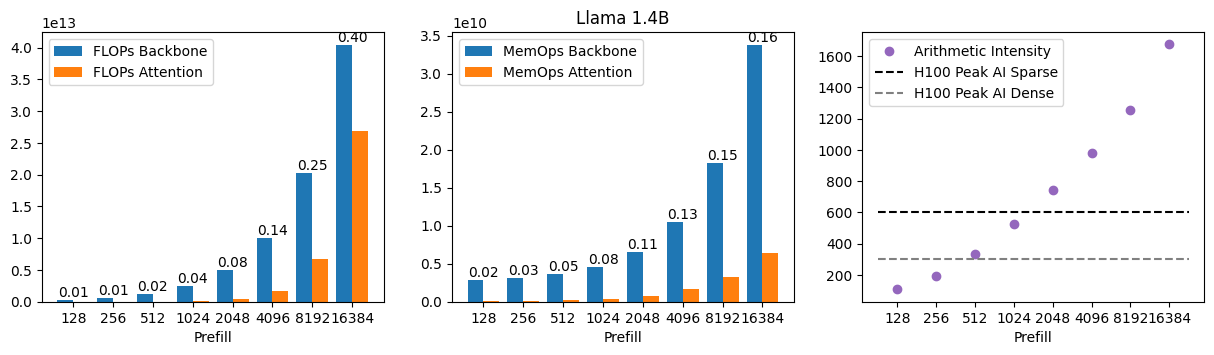

In [6]:
seq_lens = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
config = llama_1_4b

f, axs = plt.subplots(1, 3, figsize=(15, 3.5))

# calculate per
for s, seq_len in enumerate(seq_lens):
    flops_backbone = seq_len * count_flops_llama_backbone(
        n_vocab=config["vocab_size"],
        n_blocks=config["num_layers"],
        d_ff=config["d_ff"],
        n_headq=config["num_heads"],
        d_qk=config["d_kv"],
        d_hv=config["d_kv"],
        n_headkv=config["num_heads"],
        with_unembed=False,
    )
    flops_attn = config["num_layers"] * count_flops_attention_prefill(
        seq_len=seq_len,
        d_qk=config["d_kv"],
        d_hv=config["d_kv"],
        n_headq=config["num_heads"],
    )

    memops_backbone = count_memops_llama_backbone(
        batch_size=1,
        seq_len=seq_len,
        n_vocab=config["vocab_size"],
        n_blocks=config["num_layers"],
        d_ff=config["d_ff"],
        n_headq=config["num_heads"],
        n_headkv=config["num_heads"],
        d_qk=config["d_kv"],
        d_hv=config["d_kv"],
        bytes_act=2,
        bytes_w=2,
        with_unembed=False,
    )

    memops_attn = config["num_layers"] * count_memops_attention_prefill(
        batch_size=1,
        seq_len=seq_len,
        d_qk=config["d_kv"],
        d_hv=config["d_kv"],
        n_headq=config["num_heads"],
        n_headkv=config["num_heads"],
        bytes_act=2,
    )

    print(flops_backbone + flops_attn)

    # stacked barplot at position s
    axs[0].bar(
        s - 0.2,
        flops_backbone,
        label="FLOPs Backbone" if s == 0 else "",
        color="C0",
        width=0.4,
    )
    axs[0].bar(
        s + 0.2,
        flops_attn,
        label="FLOPs Attention" if s == 0 else "",
        color="C1",
        width=0.4,
    )
    # text with ratio on top of bars
    axs[0].text(
        s,
        max(flops_backbone, flops_attn),
        f"{flops_attn / (flops_attn + flops_backbone):.2f}",
        ha="center",
        va="bottom",
    )
    # axs[0].set_yscale("log")

    axs[1].bar(
        s - 0.2,
        memops_backbone,
        label="MemOps Backbone" if s == 0 else "",
        color="C0",
        width=0.4,
    )
    axs[1].bar(
        s + 0.2,
        memops_attn,
        label="MemOps Attention" if s == 0 else "",
        color="C1",
        width=0.4,
    )
    # text with ratio on top of bars
    axs[1].text(
        s,
        max(memops_backbone, memops_attn),
        f"{memops_attn / (memops_attn + memops_backbone):.2f}",
        ha="center",
        va="bottom",
    )
    # axs[1].set_yscale("log")

    axs[2].plot(
        s,
        (flops_attn + flops_backbone) / (memops_attn + memops_backbone),
        "o",
        label="Arithmetic Intensity" if s == 0 else "",
        color="C4",
    )

axs[2].hlines(
    y=600,
    xmin=-0.5,
    xmax=len(seq_lens) - 0.5,
    colors="black",
    linestyles="dashed",
    label="H100 Peak AI Sparse",
)
axs[2].hlines(
    y=300,
    xmin=-0.5,
    xmax=len(seq_lens) - 0.5,
    colors="gray",
    linestyles="dashed",
    label="H100 Peak AI Dense",
)

# plt.yscale("log")
for ax in axs:
    ax.set_xticks(ticks=np.arange(len(seq_lens)), labels=seq_lens)
    ax.set_xlabel("Prefill")
    ax.legend()
axs[1].set_title("Llama 1.4B")
plt.show()